# Notebook 05: Baseline Linear Models

## About this notebook

This notebook contains a set of baseline linear models created to predict `Budget_Change_Ratio` and `Schedule_Change_Ratio` using the small set of valid predictors available in our original dataset (therefore, no engineered features were used here.

## Summary of findings

- Sigmoid scaled `Budget_Start` and `Duration_Start` predictor data sufficiently minimizes skew to provide the best predictive performance amongst our linear models.


- Our two predicted outcome variables, 3-year project `Budget_Change_Ratio` and `Schedule_Change_Ratio`, both exhibit different predictive behavior.


- While our linear models fail to predict `Budget_Change_Ratio` better than a naive model, as is evidenced by negative $R^2$ test score, our `Schedule_Change_Ratio` predictions do moderately well with our best test $R^2$ score exceeding 0.54.


- Of our linear models contained in this notebook, **Ordinary Linear Regression lacks sufficient expressiveness to model our predictors** well and the remaining skew of our data, lack of uniformly distributed residuals, and poor train AND test $R^2$ scores indicate that method is ill suited for our needs.

```
"BASELINE" Linear Regression model results used the following predictors:

    ['Budget_Start', 'Duration_Start']
    

    R-squared scores:
    
        Budget_Change_Ratio

            Training	0.0116
            Test		-0.3509

        Schedule_Change_Ratio

            Training	0.2332
            Test		0.2697
            

"BASELINE+" Linear Regression model using the project Category as one-hot-encoded predictors:

    ['Budget_Start', 'Duration_Start', 'Bridges', 'Ferries', 'Industrial_Development', 'Parks', 'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways', 'Wastewater_Treatment', 'Water_Supply']
    
    
    R-square scores:
    
        Budget_Change_Ratio

            Training	0.0686
            Test		-2.5340

        Schedule_Change_Ratio

            Training	0.4523
            Test		0.3364

```    

<br>

- On the otherhand, our **smoothing spline GAM model with separately optimized $\lambda$ term penalties for each specific predicted outcome variable `Budget_Change_Ratio` and `Schedule_Change_Ratio`** (as is shown in the separate notebook titled `06_smoothing_spline_models.ipynb`) demonstrated enough improvement in our $R^2$ scores using just these initial 3 predictors to offer hope that a combination of additional engineered features and a sufficiently expressive model, might give us some form of acceptable predictive performance.

```
"BASELINE+" Smoothing Spline GAM results with optimized term penalties by response variable and a label-encoded `Category` predictor:

    ['Budget_Start', 'Duration_Start', `Category_Code`]
    

    R-squared scores:
    
        Budget_Change_Ratio

            Training	0.8263
            Test		-0.8736

        Schedule_Change_Ratio

            Training	0.5800
            Test		0.5373

```

<br>


In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  RobustScaler, LabelEncoder

import statsmodels.formula.api as sm
from pygam import LinearGAM, s, f

# import custom .py functions from src/ directory 
sys.path.append('..')
from src.datagen import print_interval_dict
from src.scale import scale_features, sigmoid, log_plus_one, encode_categories
from src.model import generate_model_dict, print_model_results
from src.visualize import plot_true_pred, plot_bdgt_sched_scaled, \
                          plot_change_trend, plot_gam_by_predictor, \
                          plot_coefficients


# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphics
%config InlineBackend.figure_format ='retina'

In [2]:
filepath_train = '../data/processed/NYC_capital_projects_3yr_final_train.csv'
filepath_test = '../data/processed/NYC_capital_projects_3yr_final_test.csv'
filepath_full = '../data/interim/Capital_Projects_clean.csv'

error = None
for filepath in [filepath_train, filepath_test, filepath_full]: 
    if not os.path.isfile(filepath):
        error = 1
        print(
            "ERROR - the following target file does not exist:\n\n\t{}\n"\
            "".format(filepath)
        )

if error is None:
    print("OK - all filepaths point to existing files!")

OK - all filepaths point to existing files!


In [3]:
data_train = pd.read_csv(filepath_train)
data_test = pd.read_csv(filepath_test)
data_full = pd.read_csv(filepath_full) 

In [4]:
# entries
print(f"Number of dataset records: {len(data_train)}")

# num projects
print(f"Number of unique projects in dataset: {len(data_train['PID'].unique())}")

Number of dataset records: 134
Number of unique projects in dataset: 134


In [5]:
print('{}\t{}'.format(data_train.shape, data_test.shape))

(134, 54)	(15, 54)


In [6]:
datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data_train[col] = pd.to_datetime(data_train[col])
    data_test[col] = pd.to_datetime(data_test[col])

In [7]:
data_train.info()

data_train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  134 non-null    int64         
 1   PID                         134 non-null    int64         
 2   Project_Name                134 non-null    object        
 3   Description                 134 non-null    object        
 4   Category                    134 non-null    object        
 5   Borough                     134 non-null    object        
 6   Managing_Agency             134 non-null    object        
 7   Client_Agency               134 non-null    object        
 8   Phase_Start                 134 non-null    object        
 9   Current_Project_Years       134 non-null    float64       
 10  Current_Project_Year        134 non-null    int64         
 11  Design_Start                134 non-null    datetime64[ns]

,Unnamed: 0,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,...,umap_descr_2D_embed_1,umap_descr_2D_embed_2,umap_attributes_2D_embed_1,umap_attributes_2D_embed_2,attribute_clustering_label,ae_descr_embed_1,ae_descr_embed_2,pca_descr_embed_1,pca_descr_embed_2,attribute_km3_label
0,0,204,Edgewood Triangle Roadway Reconstruction,Reconstruct roadway and extend storm and sanit...,Streets and Roadways,Queens,DDC,DOT,2-Design,6.55,...,0.46,-0.41,12.32,10.59,4,6.10,4.54,6.02,3.01,0
1,1,577,Bronx Public School 19 Addition,Design and construction of a new school,Schools,Bronx,SCA,DOE,2-Design,2.94,...,-12.40,-3.70,8.39,-1.15,0,0.00,-0.01,-11.32,-2.94,1
2,2,664,"NEW STRM SWR & WM REPLACEMENT IN ACACIA AVE, ETC.",New Strom Sewer extension & Water Main replace...,Sewers,Staten Island,DDC,DEP,3-Construction Procurement,4.75,...,-0.47,-0.43,16.50,11.85,5,5.16,3.84,4.00,0.82,0


## Subset and scale data for X and y frames

In [8]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
    'Bridges',
    'Ferries',
    'Industrial_Development',
    'Parks',
    'Sanitation',
    'Schools',
    'Sewers',
    'Streets_and_Roadways',
    'Wastewater_Treatment',
    'Water_Supply',
    'Category_Code',
    'umap_descr_2D_embed_1',
    'umap_descr_2D_embed_2',
    'umap_attributes_2D_embed_1',
    'umap_attributes_2D_embed_2',
    'attribute_clustering_label',
    'ae_descr_embed_1',
    'ae_descr_embed_2',
    'pca_descr_embed_1',
    'pca_descr_embed_2'
]

y_cols = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]

X_train, y_train = data_train[X_cols], data_train[y_cols]
X_test, y_test = data_test[X_cols], data_test[y_cols]

In [9]:
print('{}\t{}'.format(X_train.shape, X_test.shape))
print('{}\t{}'.format(y_train.shape, y_test.shape))

(134, 22)	(15, 22)
(134, 2)	(15, 2)


In [10]:
X_train.info()
print()
y_train.info()
X_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Budget_Start                134 non-null    float64
 1   Duration_Start              134 non-null    int64  
 2   Bridges                     134 non-null    int64  
 3   Ferries                     134 non-null    int64  
 4   Industrial_Development      134 non-null    int64  
 5   Parks                       134 non-null    int64  
 6   Sanitation                  134 non-null    int64  
 7   Schools                     134 non-null    int64  
 8   Sewers                      134 non-null    int64  
 9   Streets_and_Roadways        134 non-null    int64  
 10  Wastewater_Treatment        134 non-null    int64  
 11  Water_Supply                134 non-null    int64  
 12  Category_Code               134 non-null    int64  
 13  umap_descr_2D_embed_1       134 non

,Budget_Start,Duration_Start,Bridges,Ferries,Industrial_Development,Parks,Sanitation,Schools,Sewers,Streets_and_Roadways,...,Category_Code,umap_descr_2D_embed_1,umap_descr_2D_embed_2,umap_attributes_2D_embed_1,umap_attributes_2D_embed_2,attribute_clustering_label,ae_descr_embed_1,ae_descr_embed_2,pca_descr_embed_1,pca_descr_embed_2
count,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,...,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00
mean,"103,617,509.14","1,943.45",0.12,0.01,0.12,0.02,0.04,0.11,0.13,0.18,...,5.48,-0.66,0.19,10.00,9.85,3.08,2.99,2.22,0.00,-0.00
std,"213,833,628.68",636.18,0.33,0.12,0.33,0.15,0.19,0.32,0.33,0.38,...,3.12,5.47,2.98,6.08,4.75,1.89,2.31,1.72,5.44,3.62
min,"813,000.00",663.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-13.29,-9.86,-2.88,-2.13,-1.00,0.00,-0.01,-11.32,-6.85
25%,"32,020,250.00","1,502.25",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.25,-2.76,-1.80,6.95,8.97,2.00,0.78,0.57,-3.13,-2.94
50%,"46,525,815.50","1,890.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,6.00,-0.30,0.29,11.77,10.89,3.00,2.87,2.14,1.11,-0.12
75%,"77,134,000.00","2,247.75",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,8.00,2.94,2.68,16.02,12.09,5.00,4.88,3.61,4.16,2.66
max,"1,910,339,114.55","4,360.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,10.00,12.30,10.83,17.74,15.59,5.00,11.10,8.21,12.96,8.55


In [11]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify binary variable columns to exclude from scaling
exclude_scale_cols = list(X_train)[2:]


# Standardize both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None
reapply_scaler = False


X_train_std, Scaler_std = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Standardize X_train and X_test, pass through sigmoid transformation
# and re-standardize to minimize skew of data
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid
reapply_scaler = True


X_train_std_sig, Scaler_std_sig = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

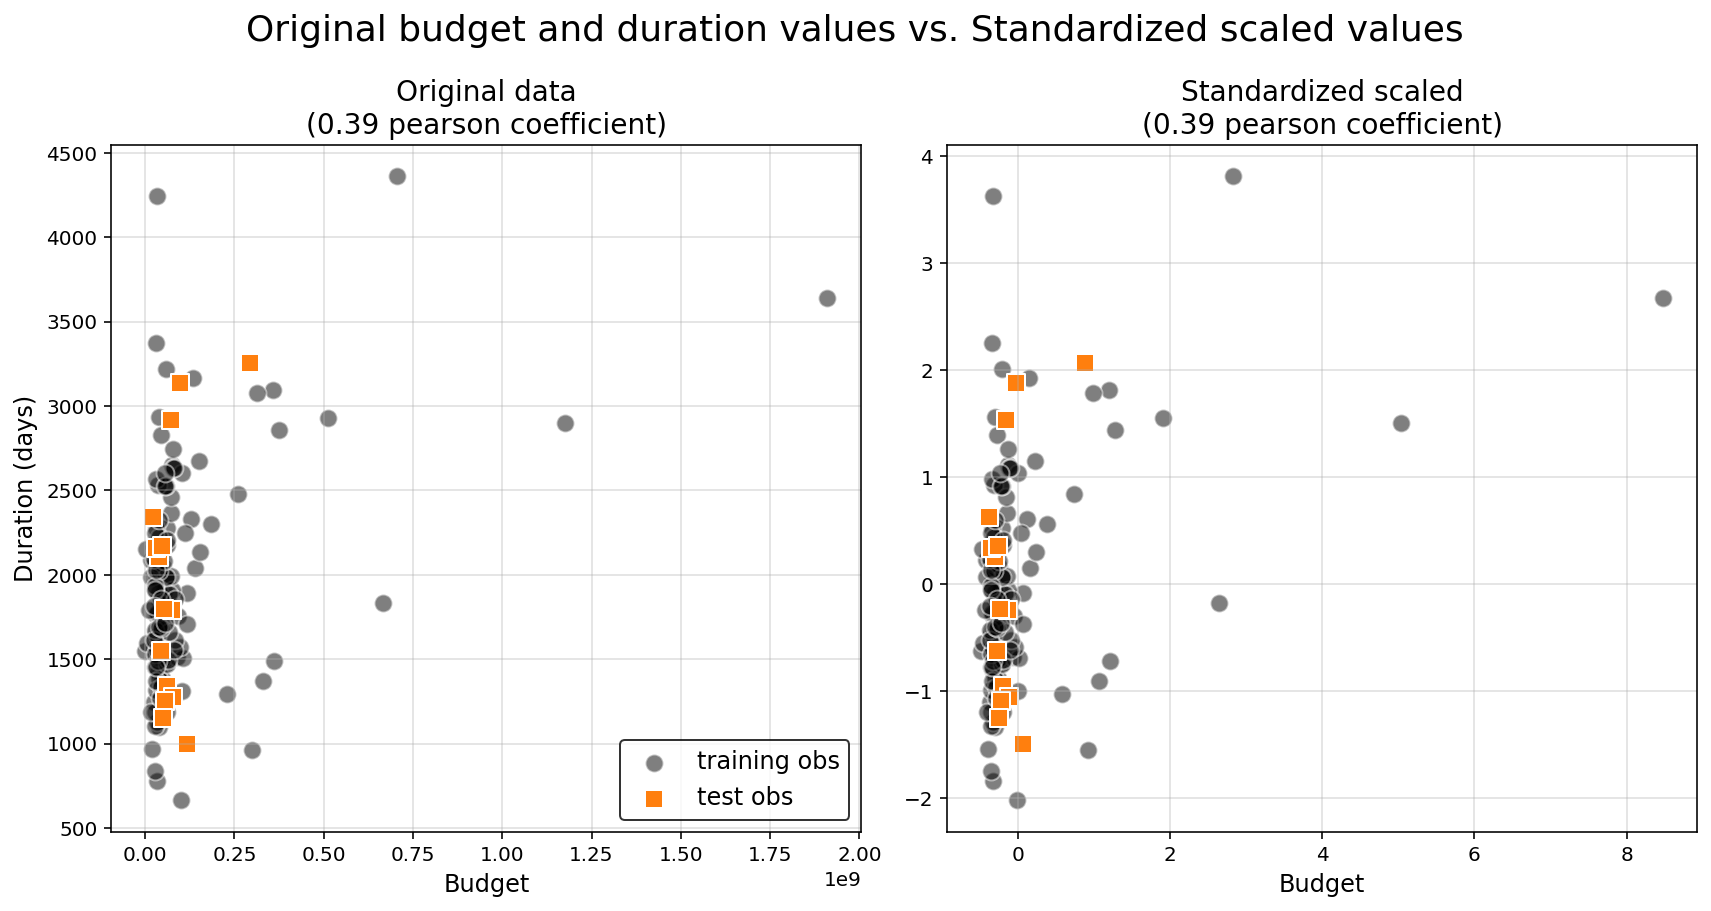

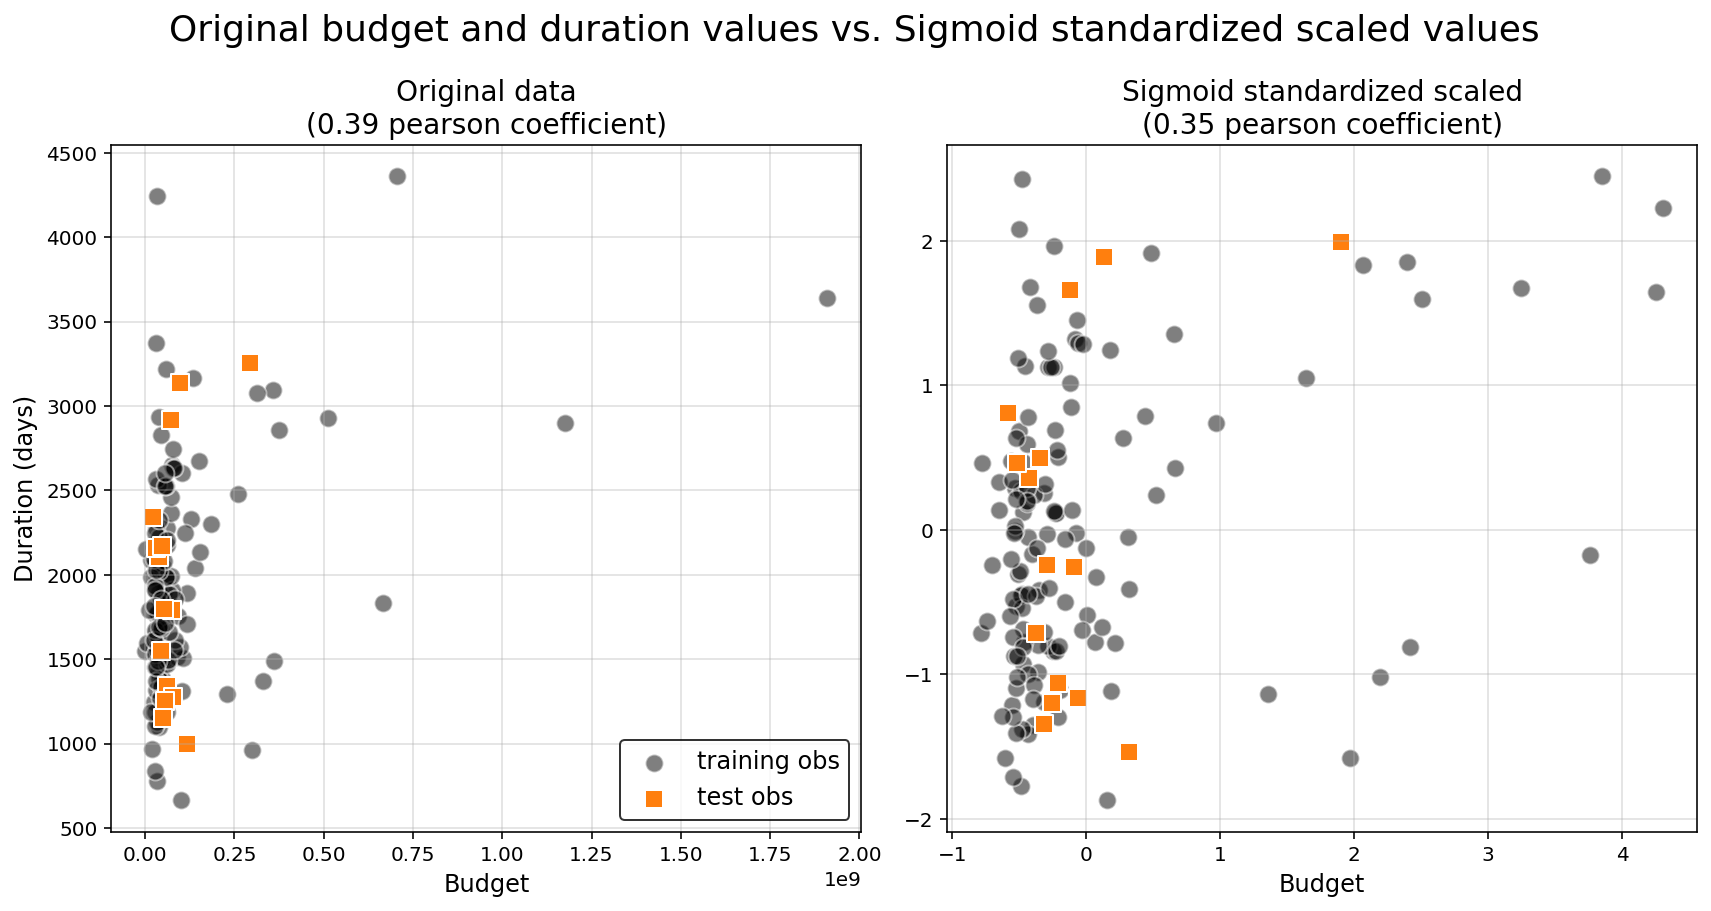

In [12]:
# inspect scaled datasets
plot_bdgt_sched_scaled(X_train, X_train_std, 'Standardized', X_test, X_test_std)
plot_bdgt_sched_scaled(X_train, X_train_std_sig, 'Sigmoid standardized', X_test, X_test_std_sig)

**FINDINGS**:

By visualizing our `Budget_Start` and `Duration_Start` predictors above, we can see a large skew with clear outliers in the original unscaled data. By applying standardization to the these predictors, as we have illustrated in the upper righthand plot, we have set both variables to the same scale. However, standardizing has not alleviated the skewness of our data or helped with our outlying datapoints. 

Therefore, we have also applied a sigmoid transformation to the data and re-standardized, as is shown in the lower righthand plot. This sigmoid transformation has helped to alleviate the skew of our data, and it has also helped to more evenly distrubute all of our data points, drawing outliers far closer to the center of the distribution.

**Now we will fit a "Baseline" linear regression model on our scaled datasets to see which performs best.**

## Fit "Baseline" linear regression model using only `Budget_Start` and `Duration_Start` predictors

In [13]:
features = [
    'Budget_Start',
    'Duration_Start'
]

print(
    '\nThese 2 "BASELINE" models used the following predictors:\n\n\t{}\n\n'\
    ''.format(features)
)


sm_formulas = [
    ' + '.join(features),
    ' + '.join(features)
]

model_descr = 'Baseline linear regression, standardized data, 2 predictors'

model_LR2 = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std[features], X_test_std[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)

print_model_results(model_LR2)

model_descr = 'Baseline linear regression, sigmoid standarized data, 2 predictors'

model_LR2_sig = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)


print_model_results(model_LR2_sig)


These 2 "BASELINE" models used the following predictors:

	['Budget_Start', 'Duration_Start']



MODEL SUMMARY:
Baseline linear regression, standardized data, 2 predictors


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0046
		Test		-0.4248

	Schedule_Change_Ratio

		Training	0.2260
		Test		0.2391




MODEL SUMMARY:
Baseline linear regression, sigmoid standarized data, 2 predictors


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0116
		Test		-0.3509

	Schedule_Change_Ratio

		Training	0.2332
		Test		0.2697





**FINDINGS:**

By using sigmoid scaled data for both our `Budget_Start` and `Schedule_Start` predictors, we can see that by reducing skew in our predictors, we have generated slightly better performance in predicting both `Budget_Change_Ratio` and `Schedule_Change_Ratio` in both our train and test sets.

While these are just true Baseline models in which we use Linear Regression with only 2 predictors, the results indicate that:

1. we may benefit from the use of sigmoid scaled data for those two baseline predictors


2. `Budget_Change_Ratio` may prove more difficult to predict than `Schedule_Change_Ratio`, wherein our predictions for `Budget_Change_Ratio` perform less well than a naive model as is indicated by the negative $R^2$ score for the test data.

## Fit "Baseline+" regression model, incorporating project `Category` as a predictor

In [14]:
features = list(X_train)[:-10]

print(
    '\nThis "BASELINE+" model uses the project Category '\
    'as one-hot-encoded predictors:'\
    '\n\n\t{}\n\n'.format(features)
)


sm_formulas = [
    ' + '.join(features),
    ' + '.join(features)
]

model_descr = 'Baseline linear regression, sigmoid standarized data, with categories'

model_LR3 = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)


print_model_results(model_LR3)


This "BASELINE+" model uses the project Category as one-hot-encoded predictors:

	['Budget_Start', 'Duration_Start', 'Bridges', 'Ferries', 'Industrial_Development', 'Parks', 'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways', 'Wastewater_Treatment', 'Water_Supply']



MODEL SUMMARY:
Baseline linear regression, sigmoid standarized data, with categories


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0686
		Test		-2.5340

	Schedule_Change_Ratio

		Training	0.4523
		T

**FINDINGS:**

By adding the one-hot-encoded `Category` feature to our model, which provides information about the type of project for each observation, we can see a clear improvement in our `Schedule_Change_Ratio` $R^2$ scores for both train and test predictions. 

Our `Budget_Change_Ratio` results on the otherhand have degraded in performance when compared to our simpler **Baseline** model with just 2 predictors. Regardless, neither the **Baseline** nor **Baseline+** linear regression models are able to predict 3-year `Budget_Change_Ratio` results better than the naive model, as is indicated by these $R^2$ results.

This indicates to us that we will likely have more difficulty in predicting `Budget_Change_Ratio` in our future models and that a Linear Regression model likely lacks the expressiveness required to adequately fit a model to the underlying relationship between predictors and outcome variable.

As on last step before moving on from Linear Regression, we will quickly inspect the predictions made by our **Baseline+** model, as well as the regression coefficients.


## Visualize Baseline+ predictions and coefficients

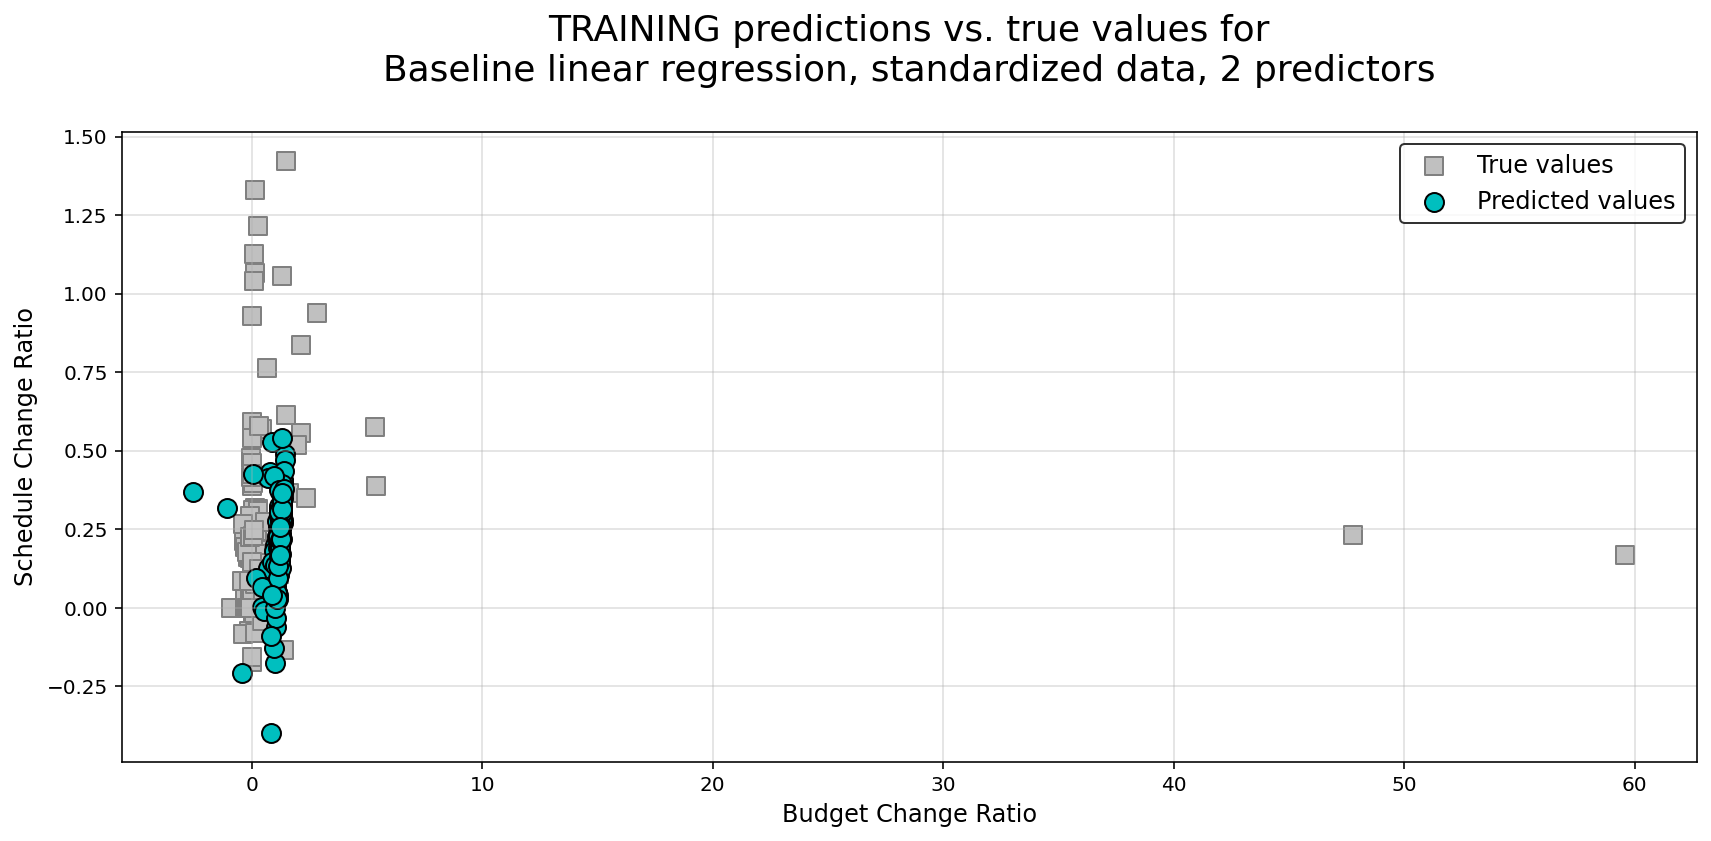

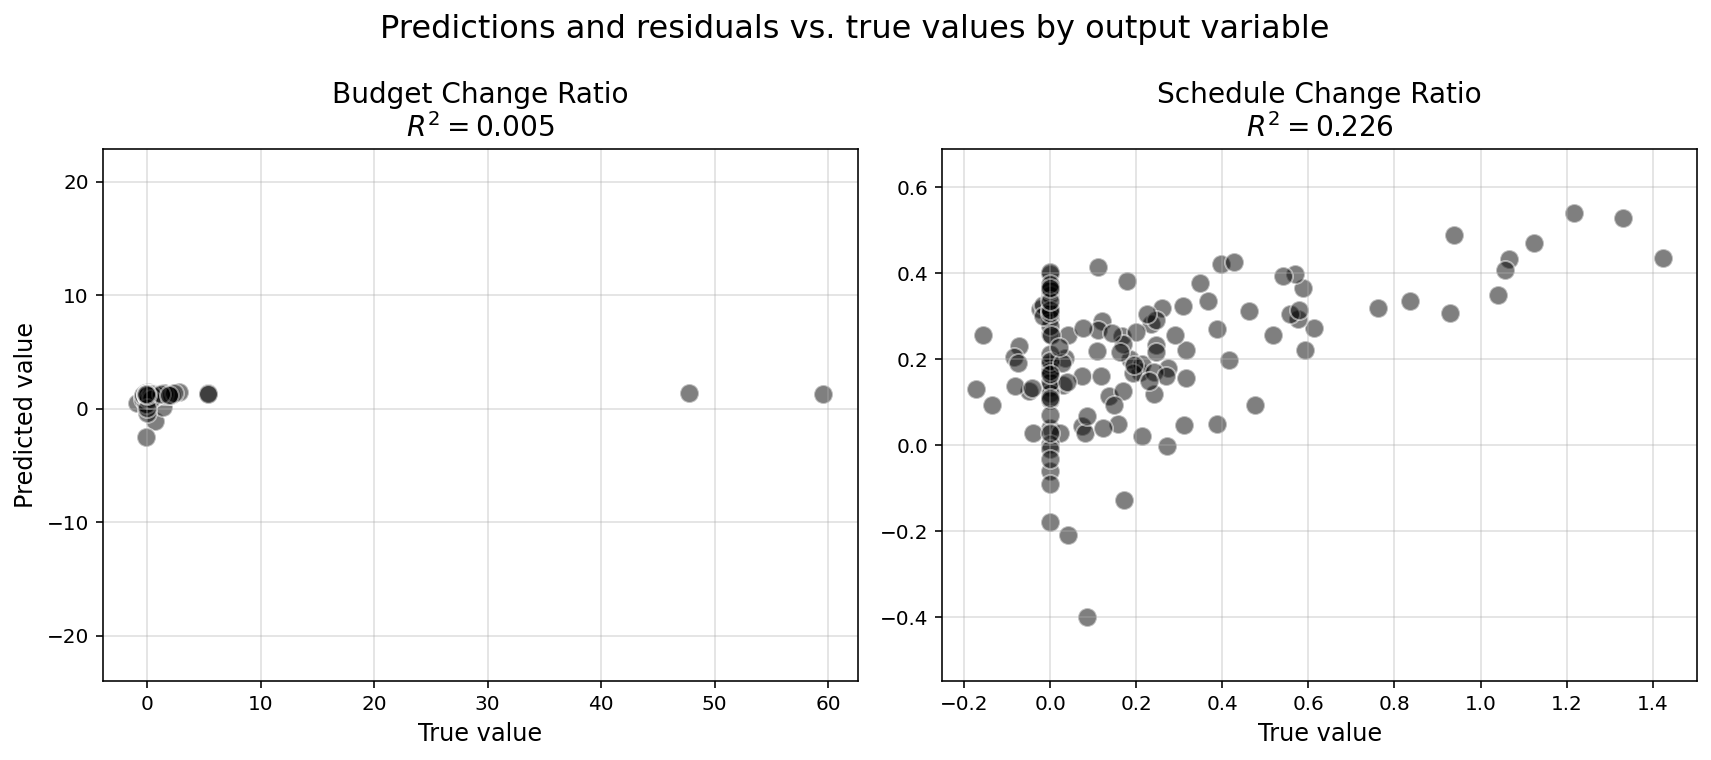

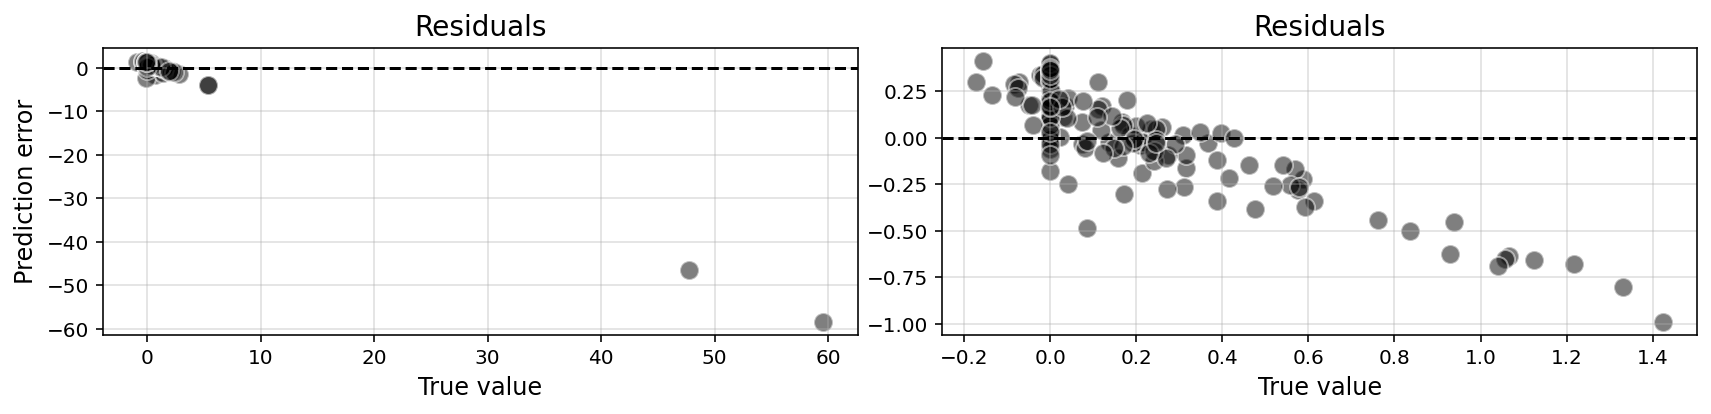

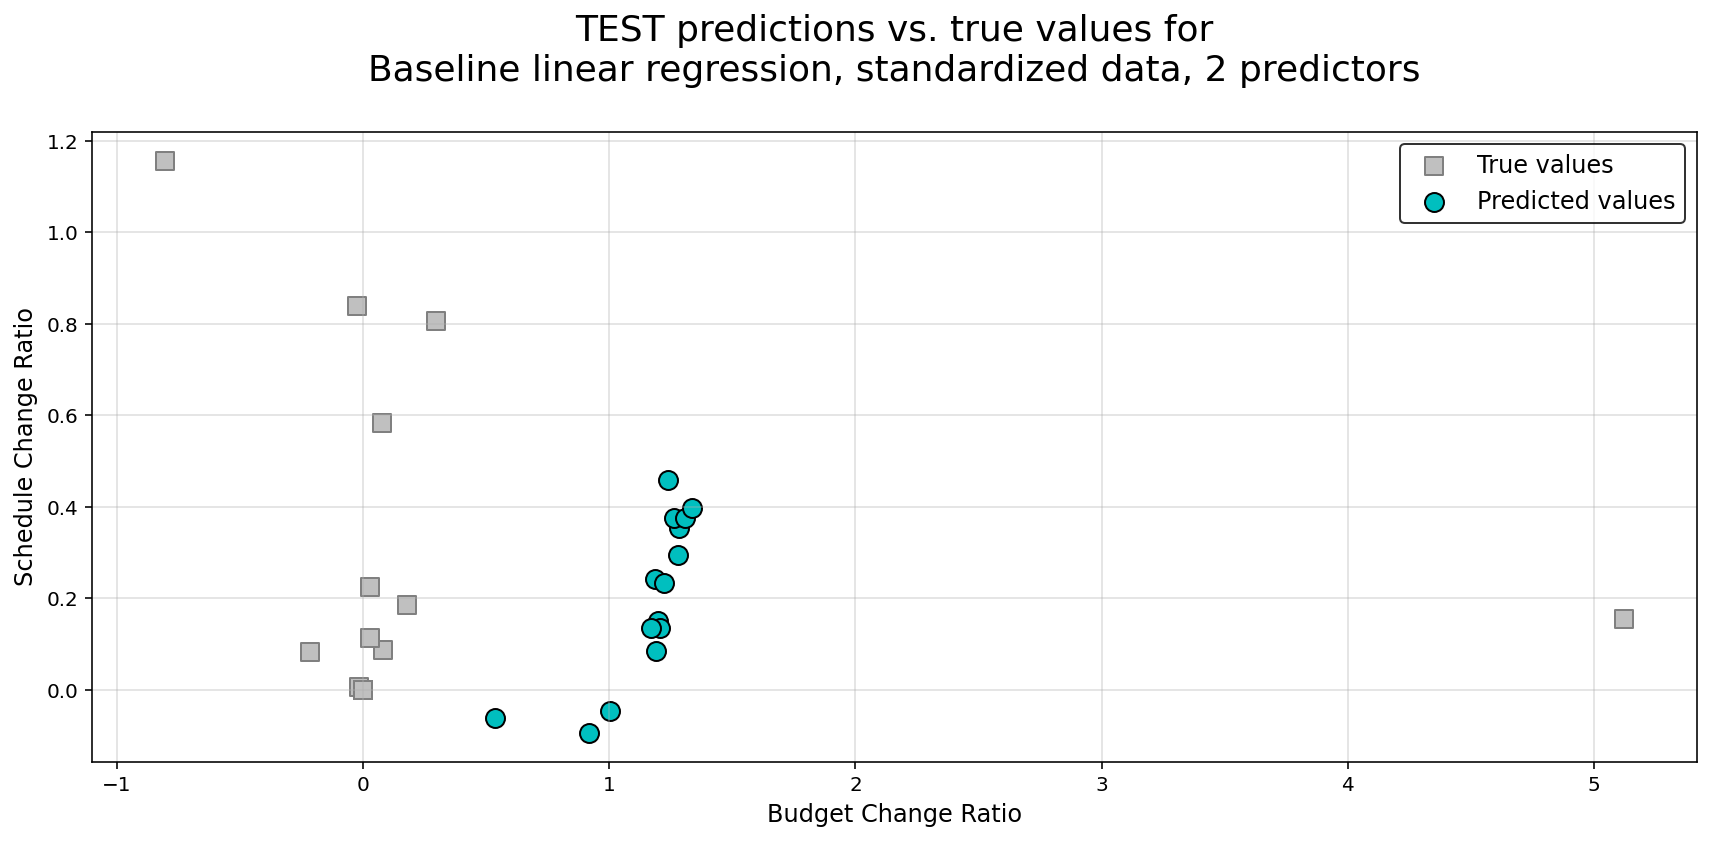

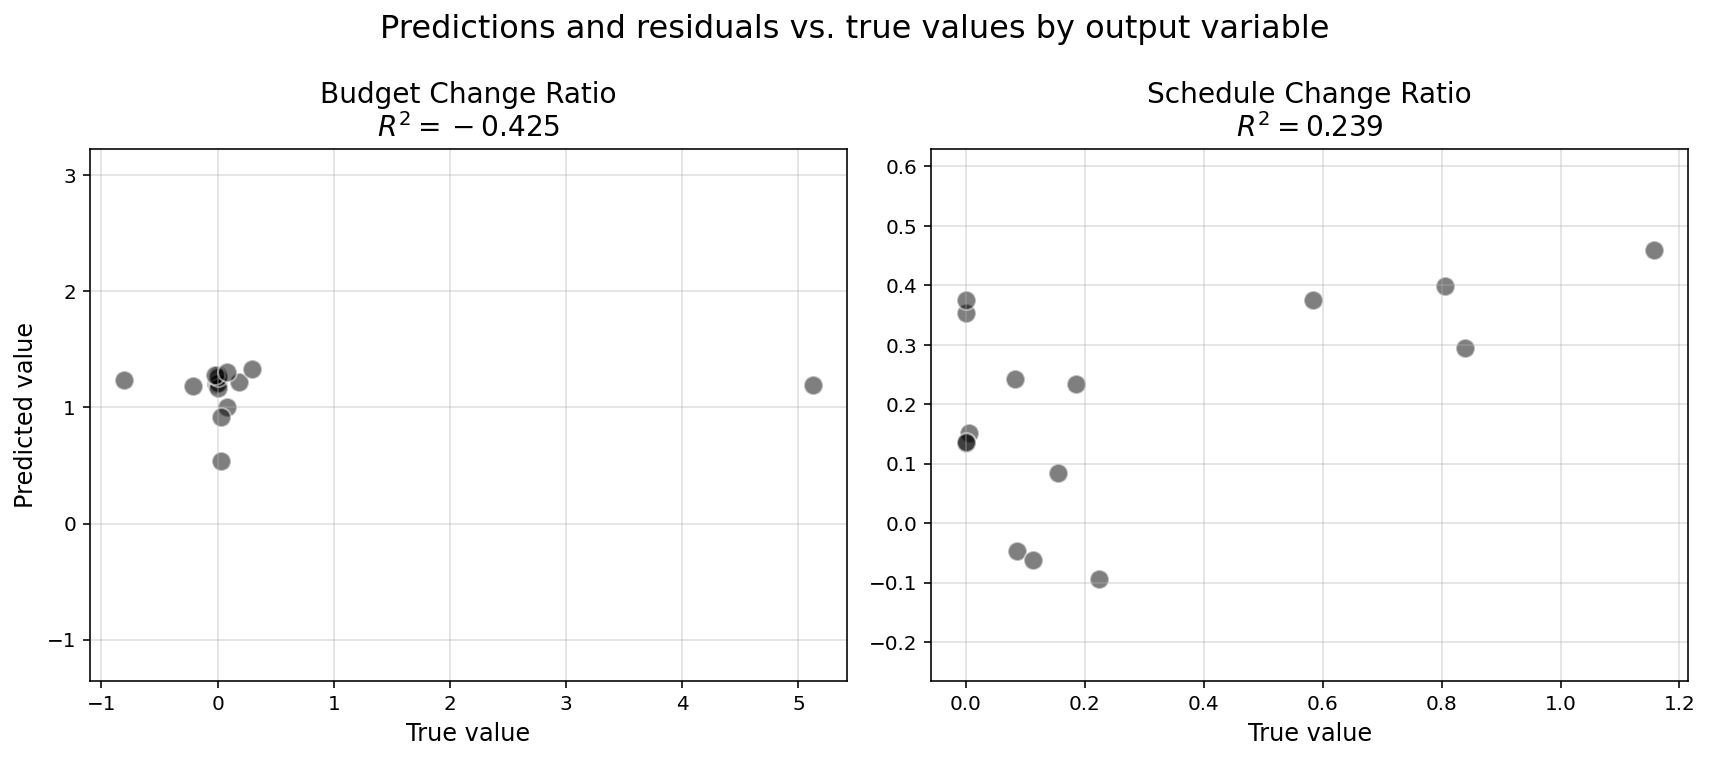

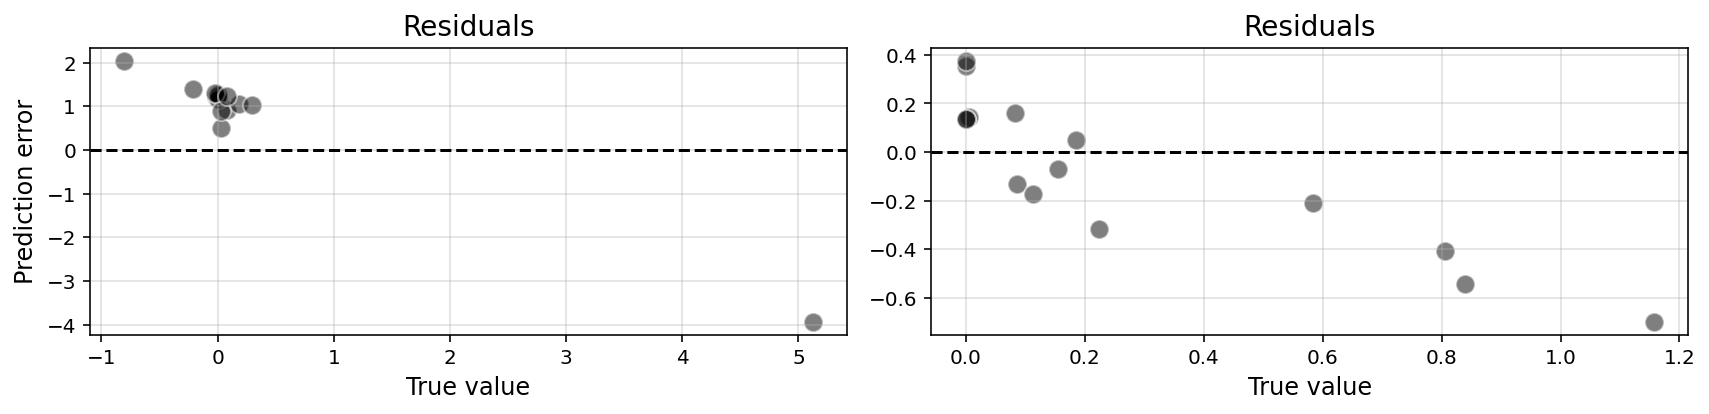

In [15]:
plot_true_pred(model_dict=model_LR2, dataset='train')
plot_true_pred(model_dict=model_LR2, dataset='test')

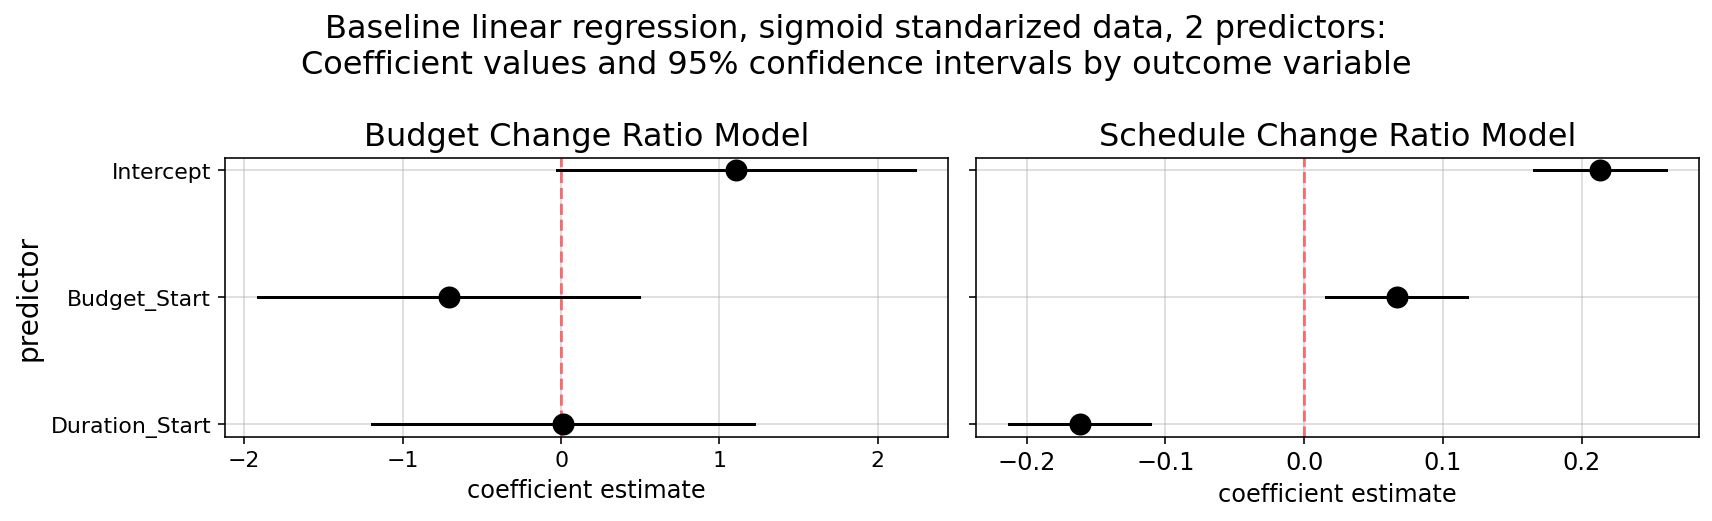

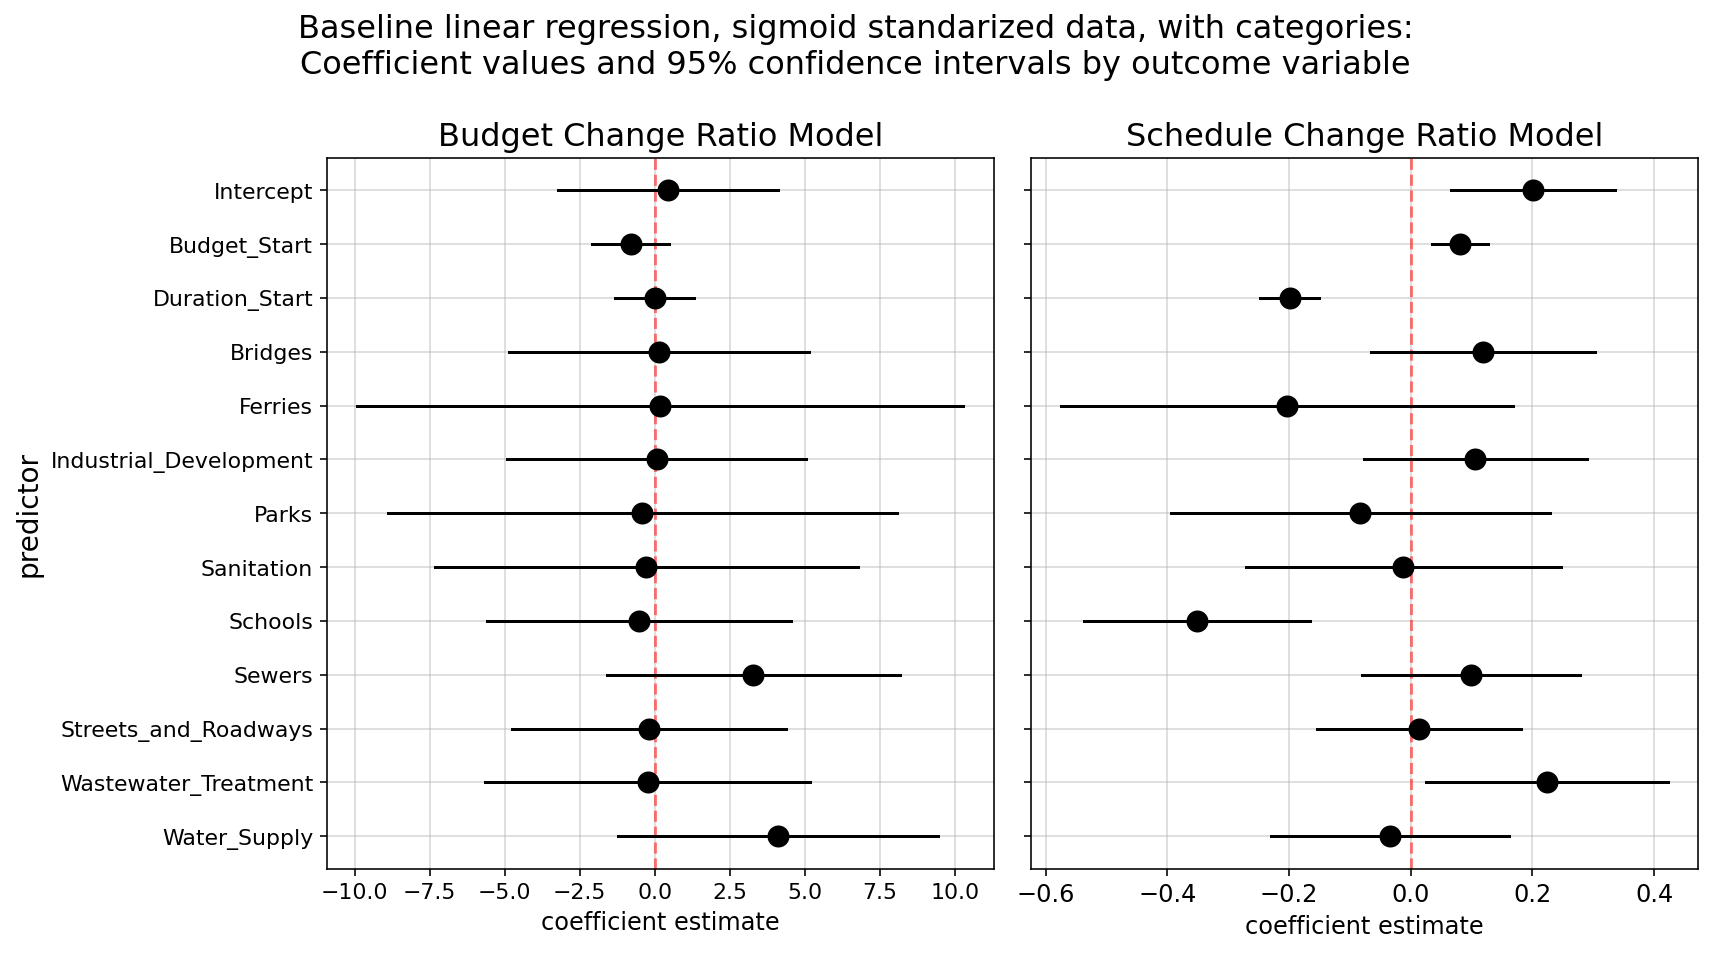

In [16]:
plot_coefficients(model_LR2_sig, fig_height=3, suptitle_spacing=1.20)
plot_coefficients(model_LR3, fig_height=6, suptitle_spacing=1.10)